In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

from sklearn.metrics import (
    ConfusionMatrixDisplay, PrecisionRecallDisplay, 
    make_scorer, recall_score, precision_score, f1_score
)

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.model_selection import (
    cross_validate,
    train_test_split,
    RandomizedSearchCV,
)
from scipy.stats import loguniform
from ucimlrepo import fetch_ucirepo 

In [2]:
cols =[
 'fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'color'
]

In [3]:
wine_quality = fetch_ucirepo(id=186) 
wine = pd.DataFrame(wine_quality.data.original) 

In [4]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
train_df, test_df = train_test_split(wine, test_size=0.3, shuffle=True, random_state=123)

In [6]:
train_df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
2457,6.7,0.22,0.39,10.2,0.038,60.0,149.0,0.99725,3.17,0.54,10.0,7,white
524,9.2,0.43,0.49,2.4,0.086,23.0,116.0,0.99760,3.23,0.64,9.5,5,red
4551,6.1,0.27,0.25,1.8,0.041,9.0,109.0,0.99290,3.08,0.54,9.0,5,white
5954,6.4,0.31,0.28,2.5,0.039,34.0,137.0,0.98946,3.22,0.38,12.7,6,white
3759,6.0,0.33,0.38,9.7,0.040,29.0,124.0,0.99540,3.47,0.48,11.0,6,white


In [7]:
X_train = train_df.drop(columns=["color"])
X_test = test_df.drop(columns=["color"])
y_train = train_df["color"]
y_test = test_df["color"]

In [8]:
# 2. Transformations if needed
categorical_features = ["color"]
ordinal_features = ["quality"]
numerical_features = [col for col in wine.columns if col != "color" and col != "quality"]

preprocessor = make_column_transformer(
    (OrdinalEncoder(dtype=int), ordinal_features),
    (StandardScaler(), numerical_features),
    remainder='passthrough' 
)

In [9]:
pipe = make_pipeline(
    preprocessor, 
    LogisticRegression(random_state=123, max_iter=1000, class_weight="balanced"),
)

In [10]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'int'>),
                                                  ['quality']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['fixed_acidity',
                                                   'volatile_acidity',
                                                   'citric_acid',
                                                   'residual_sugar',
                                                   'chlorides',
                                                   'free_sulfur_dioxide',
                                                   'total_sulfur_dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=123))])

In [11]:
scoring = {
    "accuracy": 'accuracy',
    'precision': make_scorer(precision_score, pos_label = 'red'),
    'recall': make_scorer(recall_score, pos_label = 'red'),
    'f1': make_scorer(f1_score, pos_label = 'red')
}
pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score = True, cv = 5, scoring = scoring)
).agg(['mean', 'std']).round(3).T

,mean,std
fit_time,0.022,0.033
score_time,0.014,0.004
test_accuracy,0.994,0.002
train_accuracy,0.994,0.001
test_precision,0.986,0.008
train_precision,0.987,0.003
test_recall,0.991,0.005
train_recall,0.990,0.001
test_f1,0.988,0.005
train_f1,0.989,0.001


In [12]:
param_grid = {
    "logisticregression__C": loguniform(1e-1, 10)
}
random_search = RandomizedSearchCV(
    pipe,
    param_grid,
    n_iter = 100,
    verbose = 1,
    n_jobs = -1,
    random_state = 123,
    return_train_score = True, 
    scoring = make_scorer(f1_score, pos_label = 'red')
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinalencoder',
                                                                               OrdinalEncoder(dtype=<class 'int'>),
                                                                               ['quality']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['fixed_acidity',
                                                                                'volatile_acidity',
                                                                                'citric_acid',
                                                                                'residual_sugar',
                                                                                'chlorides',
                                                                                'free_sulfur_dioxide',
                                                                                'total_sulfur_dioxide',
                                                                                'de...
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000,
                                                                 random_state=123))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15240bb30>},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=red),
                   verbose=1)

In [13]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score"
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,1,1,1,1,1,1,1,1,1,...,90,90,90,90,90,90,90,98,98,100
mean_train_score,0.988729,0.988729,0.988729,0.988729,0.988617,0.988617,0.988617,0.988617,0.988729,0.988729,...,0.986722,0.986278,0.986389,0.986833,0.986722,0.986278,0.986278,0.985835,0.985504,0.984944
mean_test_score,0.988756,0.988756,0.988756,0.988756,0.988756,0.988756,0.988756,0.988756,0.988756,0.988756,...,0.986087,0.986087,0.986087,0.986087,0.986087,0.986087,0.986087,0.985638,0.985638,0.985178
param_logisticregression__C,1.681857,1.827899,1.607386,1.667428,2.304632,1.856957,2.180859,2.235518,1.796793,1.777489,...,0.200565,0.155391,0.174284,0.207931,0.202368,0.146686,0.152830,0.131630,0.122231,0.107711
mean_fit_time,0.016504,0.018062,0.016543,0.016904,0.015681,0.022262,0.013797,0.012489,0.016107,0.010065,...,0.011566,0.013800,0.014335,0.014774,0.012782,0.011906,0.018871,0.022465,0.012258,0.012500


In [14]:
random_search.best_params_

{'logisticregression__C': np.float64(1.856957298624054)}

In [15]:
# accuracy score on test data
random_search.score(X_test, y_test)

np.float64(0.9848024316109423)

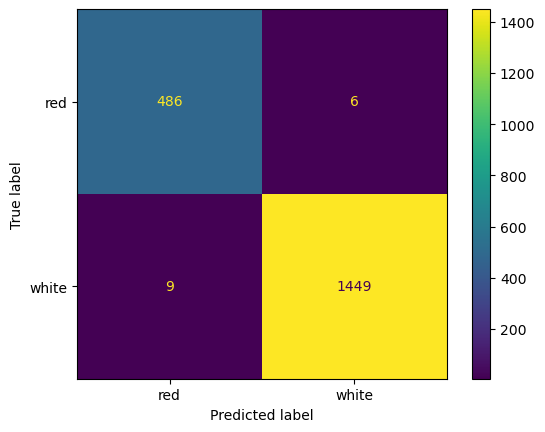

In [16]:
ConfusionMatrixDisplay.from_estimator(
    random_search,
    X_test,
    y_test,
    values_format="d",  # Show the full number 59,700 instead of 6e+04,
)

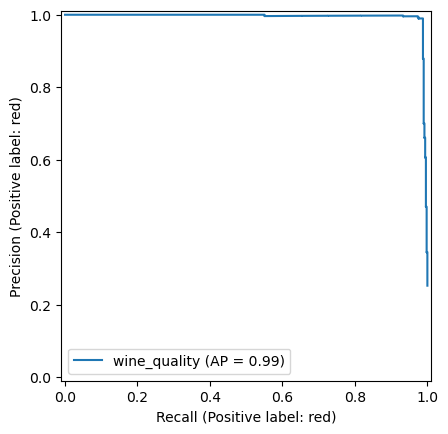

In [17]:
PrecisionRecallDisplay.from_estimator(
    random_search,
    X_test,
    y_test,
    pos_label="red",
    name='wine_quality',  # Support Vector Classifier
)

## Discussion

From the results above, we see that the logistic regression with balanced class weight performs very well in the validation set as it scores more than 0.98 for all metrics, showing both a high performance in accuracy and much less classification bias due to very high recall and precision scores. Since the validation accuracy score is very high (>0.994), we decide to do a further randomized search cross-validation using the F1 score to find an optimized hyperparameter C that can minimize our classification bias.  

Using the optimized model on the test data, we see that the model has a high accuracy score as well (0.985). Moreover, from the confusion matrix, we see that there are very few false positives (false red) and false negatives (false white) compared to the true ones. This implies that the recall and precision scores are near 1 on the test data. This is further supported by the precision-recall curve as the average precision is 0.99 and the precision score maintains constantly very close to 1 when adjusting the threshold in the model.  

With the results being near perfect with the predictions on the test data, this is out of our expectations as we would expect there will be a more flawed prediction that will not perform as great in both recall and precision in general (especially not when both recall and precision are higher than 0.98). 

The near perfect scores in the test data suggest that our model will probably do a great job in predicting the wine type given any new data. However, we also have to bear in mind that the possibility that the model might not perform as well on actual unseen data. These very high scores are quite alarming that we might have to worry that it somehow overfits on both our train and test data and cannot generalize over new unseen data.  
